In [1]:
# Data Available here:
# https://betsentiment.com/resources/dataset/italian-tweets/

# utilities
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

# viz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# model
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, Activation, Input, BatchNormalization, Embedding, GRU
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
%%time
model2vec = KeyedVectors.load_word2vec_format('../models/pretrained-italian-word2vec-emb-300.bin', binary = True)

CPU times: user 1.3 s, sys: 136 ms, total: 1.44 s
Wall time: 1.98 s


In [3]:
# picked up from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
def easy_cleaning(sentence):
    sentence = " ".join([word for word in sentence.split() if not any(x in word for x in ["@","#","http",".ly"])])
    sentence = re.sub(r"[^a-zA-Z\à\è\é\ì\ò\ù ]+", " ", sentence)
    sentence = re.sub(r" +"," ",sentence).strip().lower()
    return sentence

In [5]:
data = pd.read_csv("betsentiment-IT-tweets-sentiment-players.csv", encoding="latin1")
print("Data shape is equal to:", data.shape)
data = data[["tweet_text","sentiment"]].copy()
data = data[data["sentiment"].isin(["POSITIVE","NEGATIVE"])].copy()
print("Data - P/N labeled - shape is equal to:", data.shape)
data["tweet_text"] = data["tweet_text"].apply(func = lambda x: easy_cleaning(x))
data.drop_duplicates(inplace=True)
print("Data - unique rows (after cleaning) - shape is equal to:", data.shape)

Data shape is equal to: (165815, 6)
Data - P/N labeled - shape is equal to: (30094, 2)
Data - unique rows (after cleaning) - shape is equal to: (28760, 2)


In [6]:
n_dim = 300
input_len = 30

In [7]:
texts = list(data.tweet_text.values)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found', len(word_index), 'unique tokens')

datar = pad_sequences(sequences, maxlen=input_len)
label = np.array((data.sentiment == "POSITIVE").astype(int).values)
print('Shape of data:', datar.shape)
print('Shape of label:', label.shape)

Found 27054 unique tokens
Shape of data: (28760, 30)
Shape of label: (28760,)


In [8]:
nb_words = len(word_index)+1

embedding_matrix = np.zeros((nb_words, n_dim))
for word, i in word_index.items():
    if word in model2vec.wv.vocab:
        embedding_matrix[i] = model2vec.wv[word]

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(datar, label, test_size=.2)

In [10]:
model_input = Input(shape=(input_len,))

model = Embedding(nb_words, n_dim, weights=[embedding_matrix],input_length=input_len,
        trainable=False)(model_input)

model = GRU(128)(model) 

model = Dense(128)(model)
model = Activation('relu')(model)

model = Dense(64)(model)
model = Activation('relu')(model)

model = Dense(1)(model)
out = Activation('sigmoid')(model)

opt = SGD(lr = 0.1, momentum = 0.9, nesterov=True)

model = Model(inputs=[model_input], outputs=out)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary(), end="\n\n")

model.fit(X_train, y_train,
          batch_size=2**7,
          epochs=3,
          verbose=1,
          validation_data=(X_valid, y_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           8116500   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               164736    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

In [11]:
y_pred = (model.predict(X_valid)>.5).astype(int)

Confusion matrix, without normalization
[[ 879  393]
 [ 255 4225]]


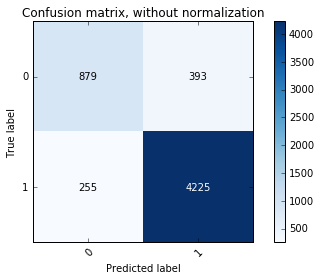

In [13]:
plot_confusion_matrix(y_valid.reshape(-1,1), y_pred, classes=np.array([0,1]))
plt.show()